In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV,cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time as time
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data_dropped.csv')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['popular'], axis = 1),
    data['popular'],
    test_size = 0.2,
    random_state = 42)

In [14]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adaboost

In [22]:
# base model
ada_base = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 1),
                           random_state = 1)
ada_base.fit(X_train_scaled, y_train)

ada_base_pred = ada_base.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, ada_base_pred))
print('Precision:', precision_score(y_test, ada_base_pred))

Accuracy: 0.6608651784588221
Precision: 0.6562342251388188


In [ ]:
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500, 1000]
grid['learning_rate'] = [0.001, 0.01,0.1, 0.5, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=10), DecisionTreeClassifier(max_depth=15),DecisionTreeClassifier(max_depth=20)]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True)
# execute the grid search
grid_result = grid_search.fit(X_train_scaled, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [28]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), learning_rate=0.01, random_state = 1,
                         n_estimators=100).fit(X_train_scaled, y_train)
ada_pred = ada_model.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, ada_pred))
print('Precision:', precision_score(y_test, ada_pred))

Accuracy: 0.742212132677513
Precision: 0.7235810971265733


In [38]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9), learning_rate=0.001, random_state = 1,
                         n_estimators=240).fit(X_train_scaled, y_train)
ada_pred = ada_model.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, ada_pred))
print('Precision:', precision_score(y_test, ada_pred))

Accuracy: 0.7505360070626813
Precision: 0.7301062573789846


In [90]:
threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9), learning_rate=0.001, random_state = 1,
                         n_estimators=240)

predicted_probability = cross_val_predict(ada_model, 
                                    X_train_scaled, y_train, cv = 2, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

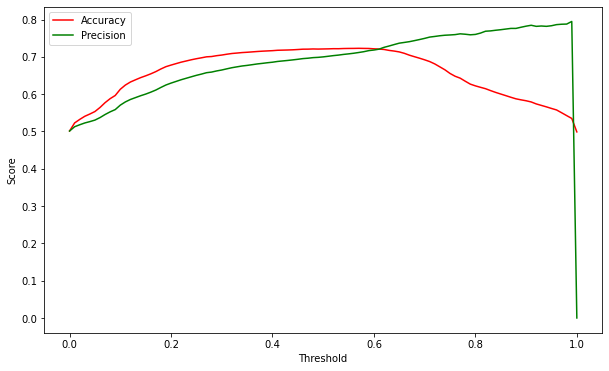

In [91]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [94]:
desired_threshold = 0.61

ada_model.fit(X_train_scaled, y_train)
ada_pred_prob = ada_model.predict_proba(X_train_scaled)[:,1] 

ada_pred = ada_pred_prob > desired_threshold
ada_pred = ada_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, ada_pred))  
print("Train Precision: ", precision_score(y_train, ada_pred))

Train Accuracy:  0.8465394923537758
Train Precision:  0.8619060120766605


In [95]:
ada_pred_prob_test = gradient_model.predict_proba(X_test_scaled)[:,1] 

ada_pred_test = ada_pred_prob_test > desired_threshold
ada_pred_test = ada_pred_test.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, ada_pred_test))  
print("Test Precision: ", precision_score(y_test, ada_pred_test))

Test Accuracy:  0.7674359944507504
Test Precision:  0.7976564732780794


# LightGBM

In [54]:
# base model
lgbm_base = LGBMClassifier(random_state=1).fit(X_train_scaled, y_train)
lgbm_base_pred = lgbm_base.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, lgbm_base_pred))
print('Precision:', precision_score(y_test, lgbm_base_pred))

Accuracy: 0.7670576365241518
Precision: 0.7566633761105627


In [132]:
lgbm_model = LGBMClassifier(random_state=1, subsample= 0.75, reg_lambda= 100, reg_alpha= 0, num_leaves= 31, n_estimators= 2000, max_depth= 2, learning_rate= 0.11, colsample_bytree = 0.75).fit(X_train_scaled, y_train)
lgbm_pred = lgbm_model.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, lgbm_pred))
print('Precision:', precision_score(y_test, lgbm_pred))

Accuracy: 0.7704628578635389
Precision: 0.7622603933283545


In [139]:
#K-fold cross validation to find optimal parameters for LightGBM regressor
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMClassifier(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train_scaled,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 10, 'reg_alpha': 10, 'num_leaves': 40, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01}
Optimal cross validation R-squared =  0.7627305778431686
Time taken =  4  minutes


In [140]:
lgbm_model = LGBMClassifier(random_state=1, subsample= 0.5, reg_lambda= 10, reg_alpha= 10, num_leaves= 40, n_estimators= 2000, max_depth= 8, learning_rate= 0.01, colsample_bytree = 0.75).fit(X_train_scaled, y_train)
lgbm_pred = lgbm_model.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, lgbm_pred))
print('Precision:', precision_score(y_test, lgbm_pred))

Accuracy: 0.7728591247319965
Precision: 0.7653519720419371


In [146]:
threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

predicted_probability = cross_val_predict(lgbm_model, 
                                    X_train_scaled, y_train, cv = 2, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

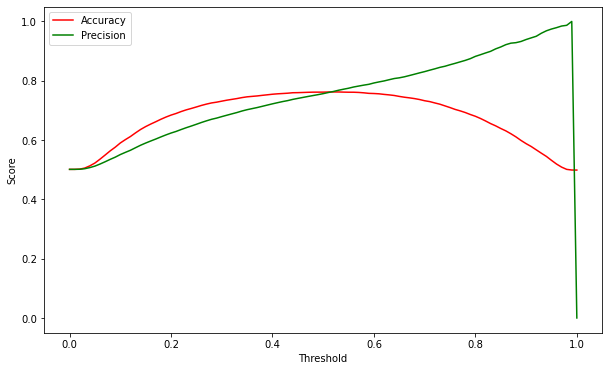

In [147]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [174]:
desired_threshold = 0.56

cat_model.fit(X_train_scaled, y_train)
cat_pred_prob = cat_model.predict_proba(X_train_scaled)[:,1] 

cat_pred = cat_pred_prob > desired_threshold
cat_pred = cat_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, cat_pred))  
print("Train Precision: ", precision_score(y_train, cat_pred))

Train Accuracy:  0.8362919754059593
Train Precision:  0.8618078561287269


In [175]:
cat_pred_prob_test = gradient_model.predict_proba(X_test_scaled)[:,1] 

cat_pred_test = cat_pred_prob_test > desired_threshold
cat_pred_test = cat_pred_test.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, cat_pred_test))  
print("Test Precision: ", precision_score(y_test, cat_pred_test))

Test Accuracy:  0.7722285281876655
Test Precision:  0.7778359968561698


# Catboost

In [98]:
# base model
cat_base = CatBoostClassifier(random_state=1, verbose = False).fit(X_train_scaled, y_train)
cat_base_pred = cat_base.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, cat_base_pred))
print('Precision:', precision_score(y_test, cat_base_pred))

Accuracy: 0.7715979316433346
Precision: 0.7637088733798604


In [103]:
threshold_vals = np.arange(0,1.01,0.01)
accuracy_iter = []
precision_iter = []

cat_model = CatBoostClassifier(random_state=1, verbose = False)

predicted_probability = cross_val_predict(cat_model, 
                                    X_train_scaled, y_train, cv = 2, method = 'predict_proba')

for threshold_prob in threshold_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
        
        accuracy = accuracy_score(y_train, predicted_class)
        precision = precision_score(y_train, predicted_class)
        accuracy_iter.append(accuracy)
        precision_iter.append(precision)

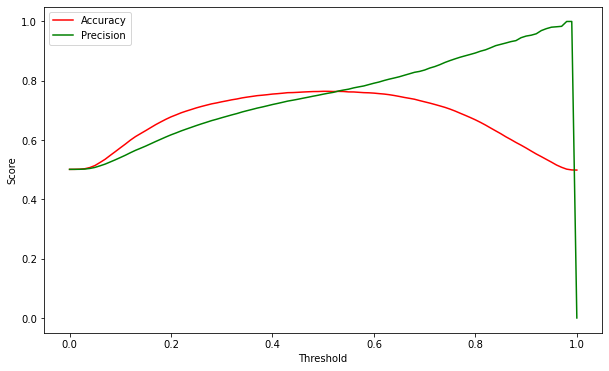

In [104]:
plt.figure(figsize=(10, 6));
plt.plot(threshold_vals, accuracy_iter, "r-", label = 'Accuracy');
plt.plot(threshold_vals, precision_iter, "g-", label = 'Precision');
plt.ylabel('Score');
plt.xlabel('Threshold');
plt.legend();

In [117]:
desired_threshold = 0.58

cat_model.fit(X_train_scaled, y_train)
cat_pred_prob = cat_model.predict_proba(X_train_scaled)[:,1] 

cat_pred = cat_pred_prob > desired_threshold
cat_pred = cat_pred.astype(int)

# Accuracy and precision

print("Train Accuracy: ", accuracy_score(y_train, cat_pred))  
print("Train Precision: ", precision_score(y_train, cat_pred))

Train Accuracy:  0.8371748384045404
Train Precision:  0.8746595908106976


In [118]:
cat_pred_prob_test = gradient_model.predict_proba(X_test_scaled)[:,1] 

cat_pred_test = cat_pred_prob_test > desired_threshold
cat_pred_test = cat_pred_test.astype(int)

# Accuracy and precision

print("Test Accuracy: ", accuracy_score(y_test, cat_pred_test))  
print("Test Precision: ", precision_score(y_test, cat_pred_test))

Test Accuracy:  0.7715979316433346
Test Precision:  0.786410395235517


# Ensembles

In [75]:
# random forest
rf_model = RandomForestClassifier(max_features = 'sqrt', max_depth = 35, min_samples_split = 6,
                                 n_estimators = 750, random_state = 1)

desired_threshold = 0.61

rf_model.fit(X_train_scaled, y_train)
rf_pred_prob = rf_model.predict_proba(X_test_scaled)[:,1] 

rf_pred = rf_pred_prob > desired_threshold
rf_pred = rf_pred.astype(int)
print("Test Accuracy: ", accuracy_score(y_test, rf_pred))  
print("Test Precision: ", precision_score(y_test, rf_pred))

Test Accuracy:  0.7565897338882583
Test Precision:  0.804513571210735


In [77]:
# gradient boosting
gradient_model = GradientBoostingClassifier(subsample= 0.6, n_estimators= 750, min_samples_split = 5, max_depth= 10, learning_rate= 0.01, n_iter_no_change = 10, random_state = 1, )

desired_threshold = 0.6
gradient_model.fit(X_train_scaled, y_train)
gradient_pred_prob = gradient_model.predict_proba(X_test_scaled)[:,1] 

gradient_pred = gradient_pred_prob > desired_threshold
gradient_pred = gradient_pred.astype(int)

print("Test Accuracy: ", accuracy_score(y_test, gradient_pred))  
print("Test Precision: ", precision_score(y_test, gradient_pred))

Test Accuracy:  0.7679404716862152
Test Precision:  0.7920514973411699


In [83]:
# gradient boosting
xgb_model = xgb.XGBClassifier(random_state = 1, objective = 'binary:logistic', scale_pos_weight = 1,
                             subsample = 0.8, reg_lambda = 10, n_estimators = 2000, 
                              max_depth = 10, learning_rate = 0.01, gamma = 0)

desired_threshold = 0.65
xgb_model.fit(X_train_scaled, y_train)
xgb_pred_prob = xgb_model.predict_proba(X_test_scaled)[:,1] 

xgb_pred = xgb_pred_prob > desired_threshold
xgb_pred = xgb_pred.astype(int)

print("Test Accuracy: ", accuracy_score(y_test, xgb_pred))  
print("Test Precision: ", precision_score(y_test, xgb_pred))

Test Accuracy:  0.7640307731113634
Test Precision:  0.8182662538699691


## Voting

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier

# Voting ensemble with XGBoost, Gradient, and Random Forest (all tree based)
#en_1=VotingClassifier(estimators = [(xgb_model),(gradient_model),(rf_model)])
#en_1.fit(X_train_scaled,y_train)
#en_1.score(X_test, y_test)

ensemble_model = VotingClassifier(estimators=[('xgb',xgb_model),('grad',gradient_model),('rf',rf_model), ('cat',cat_base), ('lgbm', lgbm_base)])
ensemble_model.fit(X_train_scaled,y_train)
ensemble_model.score(X_test_scaled, y_test)

In [ ]:
xgb_grad_rf_soft = VotingClassifier(estimators=[('xgb',xgb_model),('grad',gradient_model),('rf',rf_model), ('cat',cat_base), ('lgbm', lgbm_base)],
                                 voting='soft')
xgb_grad_rf_soft.fit(X_train_scaled,y_train)
xgb_grad_rf_soft.score(X_test_scaled, y_test)

In [ ]:
#Using Logistic regression as the meta model (final_estimator)
xgb_grad_rf_stack = StackingClassifier(estimators=[('xgb',xgb_model),('grad',gradient_model),('rf',rf_model), ('cat',cat_base), ('lgbm', lgbm_base)],
                                   final_estimator=LogisticRegression(random_state=1,max_iter=100),n_jobs=-1,
                                   cv = StratifiedKFold(n_splits=2,shuffle=True,random_state=1))
xgb_grad_rf_stack.fit(X_train_scaled,y_train)
xgb_grad_rf_stack.score(X_test_scaled, y_test)